In this Jupyter Notebook, we will provide simulation, statistical tests and optimization of a 3-dimensional Hawkes process with an approximated power-law kernel. The approximation is done with a sum of exponentials that have power-law weights:

$$
g(t|n,\epsilon,\tau_0) = \frac{n}{Z} \Big(\sum_{i = 0}^{M-1}\xi_{i}^{-(1+\epsilon)}e^{-\frac{t}{\xi_i}}\Big),
$$

where $\xi_i = \tau_0 m^i$ for $0 \leq i < M$. Parameter Z is chosen such that $\int_{0}^{\infty}g(t)dt = n$, therefore $Z = \sum_{i=0}^{M-1}(\tau_0 m^i)^{-\epsilon}$. Parameter $m$ controls the precision of the approximation and $M$ specifies the range of it. $1 + \epsilon$ term approximates the power-law decay with an identical exponent.

In [2]:
import numpy as np
import scipy.stats
import math
import matplotlib.pyplot as plt
import functools
import os, sys
current_dir = os.path.dirname(os.getcwd())
sys.path.insert(0, current_dir) 
import pyhawkes 
# pyhawkes_import module just imports pyhawkes.pyd 
# from the main directory of the library 

def ljung_box_test(x, lag):
    n = len(x)
    dex = x - x.mean()
    acf = np.zeros(lag + 1)
    for i in range(lag + 1):
        acf[i] = sum(dex[:(n-i)] * dex[i:n]) / n
    acf = acf / acf[0]
    stat = n * (n + 2) * np.sum((acf[1:lag + 1] ** 2) / np.arange(n - 1, n - lag - 1, - 1))
    lb_test = 1 - scipy.stats.chi2.cdf(stat, lag)
    return lb_test

mu = np.array([0.15, 0.1, 0.2], dtype=float)
rho = np.array([[0.1, 0.1, 0.1], [0.1, 0.1, 0.1], [0.1, 0.1, 0.1]], dtype=float)
m = np.array([[5, 5, 5], [5, 5, 5], [5, 5, 5]], dtype=float)
M = np.array([[5, 5, 5], [5, 5, 5], [5, 5, 5]], dtype=np.int32)
epsilon = np.array([[0.2, 0.2, 0.2], [0.2, 0.2, 0.2], [0.2, 0.2, 0.2]], dtype=float)
n = np.array([[0.2, 0.2, 0.2], [0.2, 0.2, 0.2], [0.2, 0.2, 0.2]], dtype=float)

dim = 3
T = 100000
max_jumps = 200000
seed = 123
hawkes = pyhawkes.sim_power_hawkes(mu, rho, m, M, epsilon, n, T, max=max_jumps, rseed=seed)

for i in range(dim):
    print("Number of events in dimension {}: {}".format(i, len(hawkes[i])))
print("")
    
print("Negative Log-likelihood: {}".format(pyhawkes.lik_power_hawkes(mu, rho, m, M, epsilon, n, hawkes, T)))
print("")

comp = pyhawkes.comp_power_hawkes(mu, rho, m, M, epsilon, n, hawkes, T)

for i in range(dim):
    _, p_value = scipy.stats.kstest(comp[i], 'expon', args=(0, 1))
    print("P-value for Kolmogorov-Smirnov test for dimension {}: {}". format(i, p_value))
    comp_var = np.var(comp[i])
    comp_limit = np.sqrt(len(comp[i])) * (comp_var - 1) / np.sqrt(8)
    comp_test = abs(scipy.stats.norm.pdf(comp_limit))
    print("P-value for Excess Dispresion test for dimension {}: {}".format(i, comp_test))
    comp_ljung_box = ljung_box_test(comp[i], lag=20)
    print("P-value for Ljung-Box test  for dimension {}: {}".format(i, comp_ljung_box))
    print("")

Number of events in dimension 0: 37020
Number of events in dimension 1: 31998
Number of events in dimension 2: 42414

Negative Log-likelihood: 199909.88187072566

P-value for Kolmogorov-Smirnov test for dimension 0: 0.4107237121834315
P-value for Excess Dispresion test for dimension 0: 0.2769529475320824
P-value for Ljung-Box test  for dimension 0: 0.388064186363823

P-value for Kolmogorov-Smirnov test for dimension 1: 0.007824686706429412
P-value for Excess Dispresion test for dimension 1: 0.39163361807222835
P-value for Ljung-Box test  for dimension 1: 0.6244058415135462

P-value for Kolmogorov-Smirnov test for dimension 2: 0.8622324710542829
P-value for Excess Dispresion test for dimension 2: 0.23995186653118977
P-value for Ljung-Box test  for dimension 2: 0.9690220197429456



As we can see, all tests are passed on a 5% significance level, so there is little doubt that the process we obtained from the simulation behaves as a Hawkes process. As a qualitative check, we can plot the quantile-quantile plot of the residual process against the exponential distribution with rate 1.

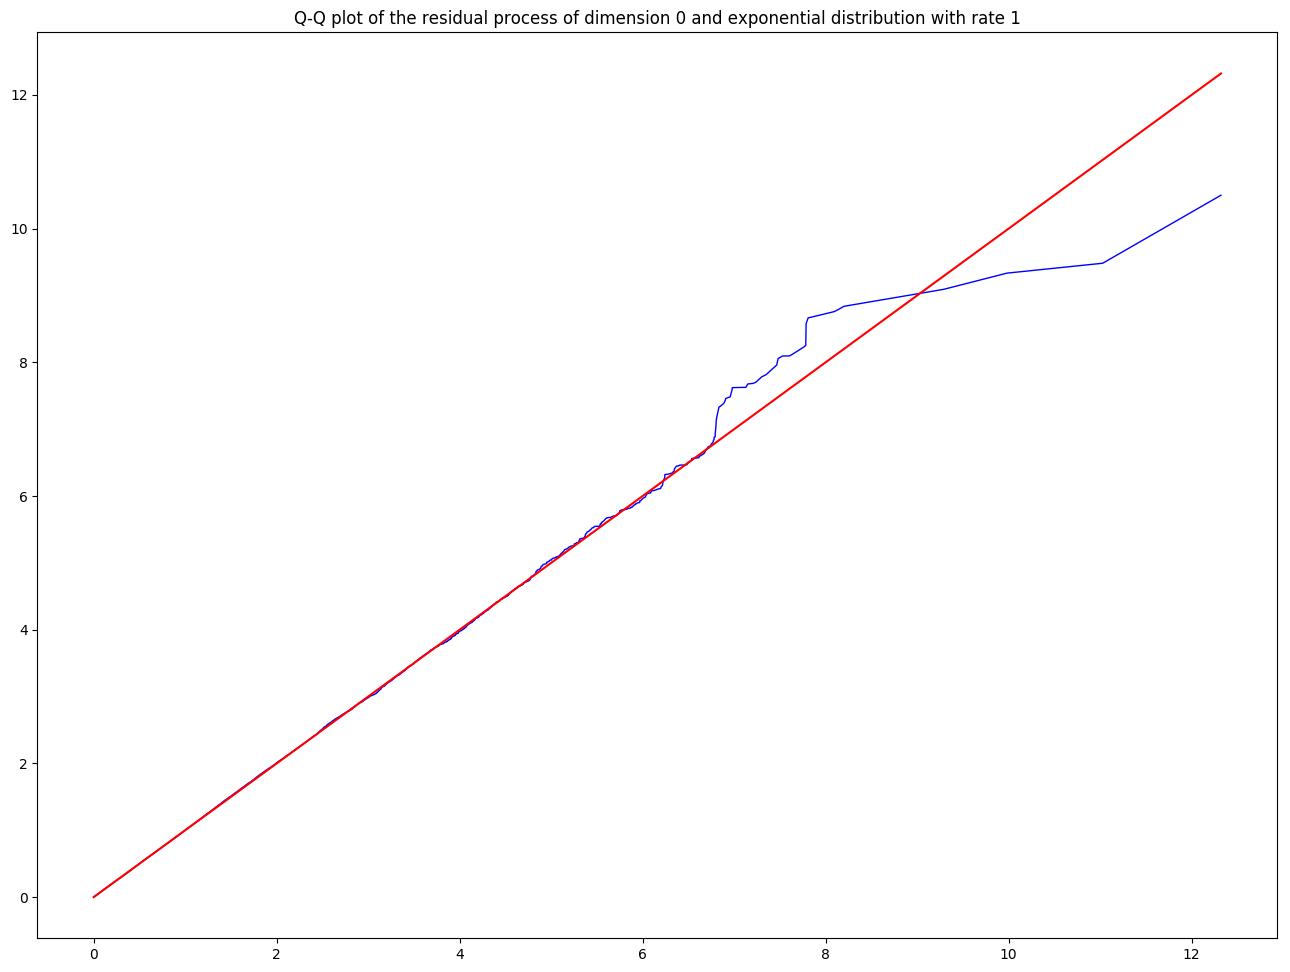

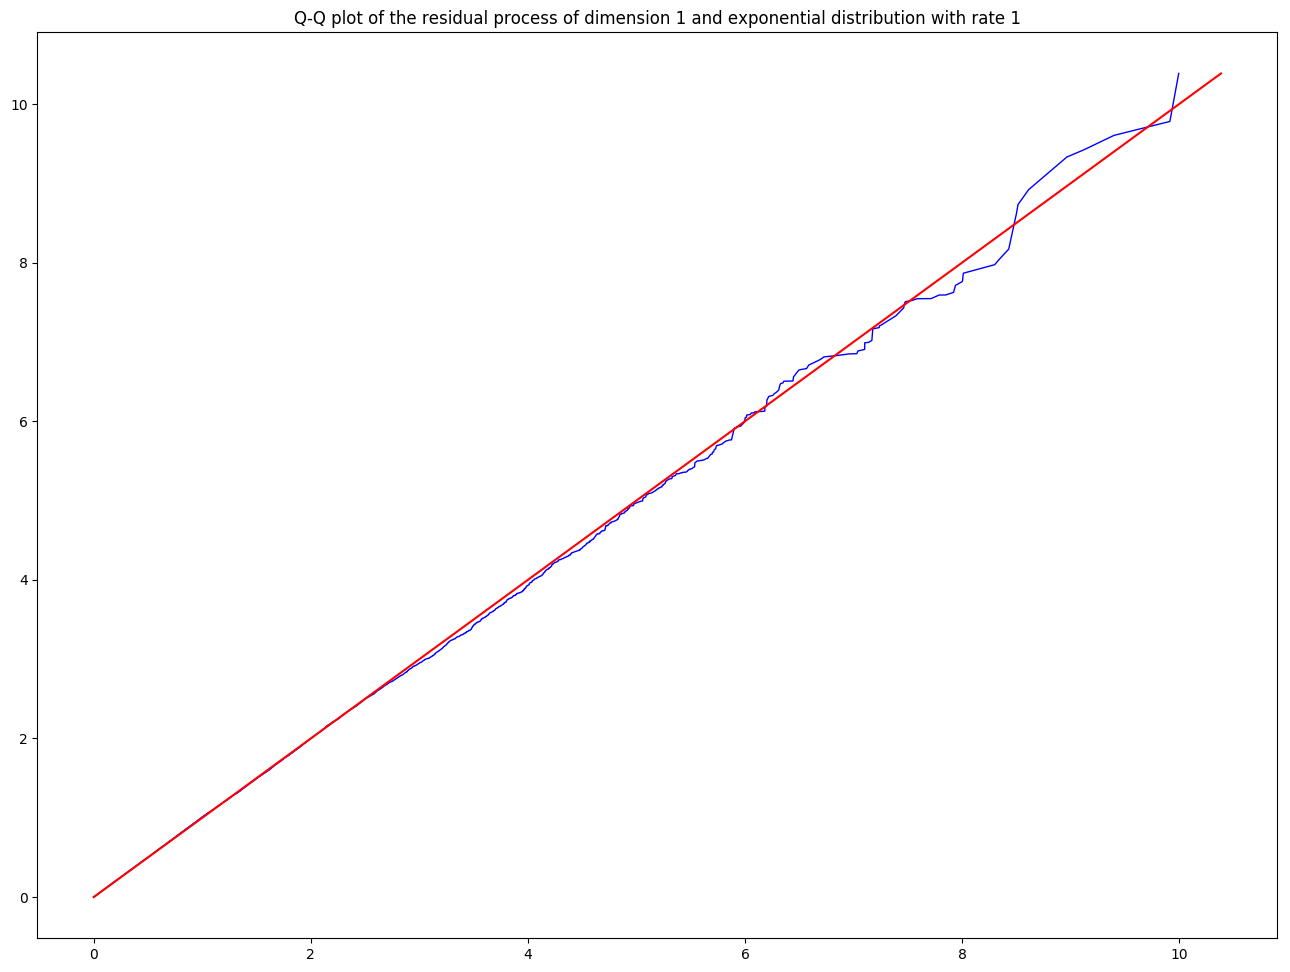

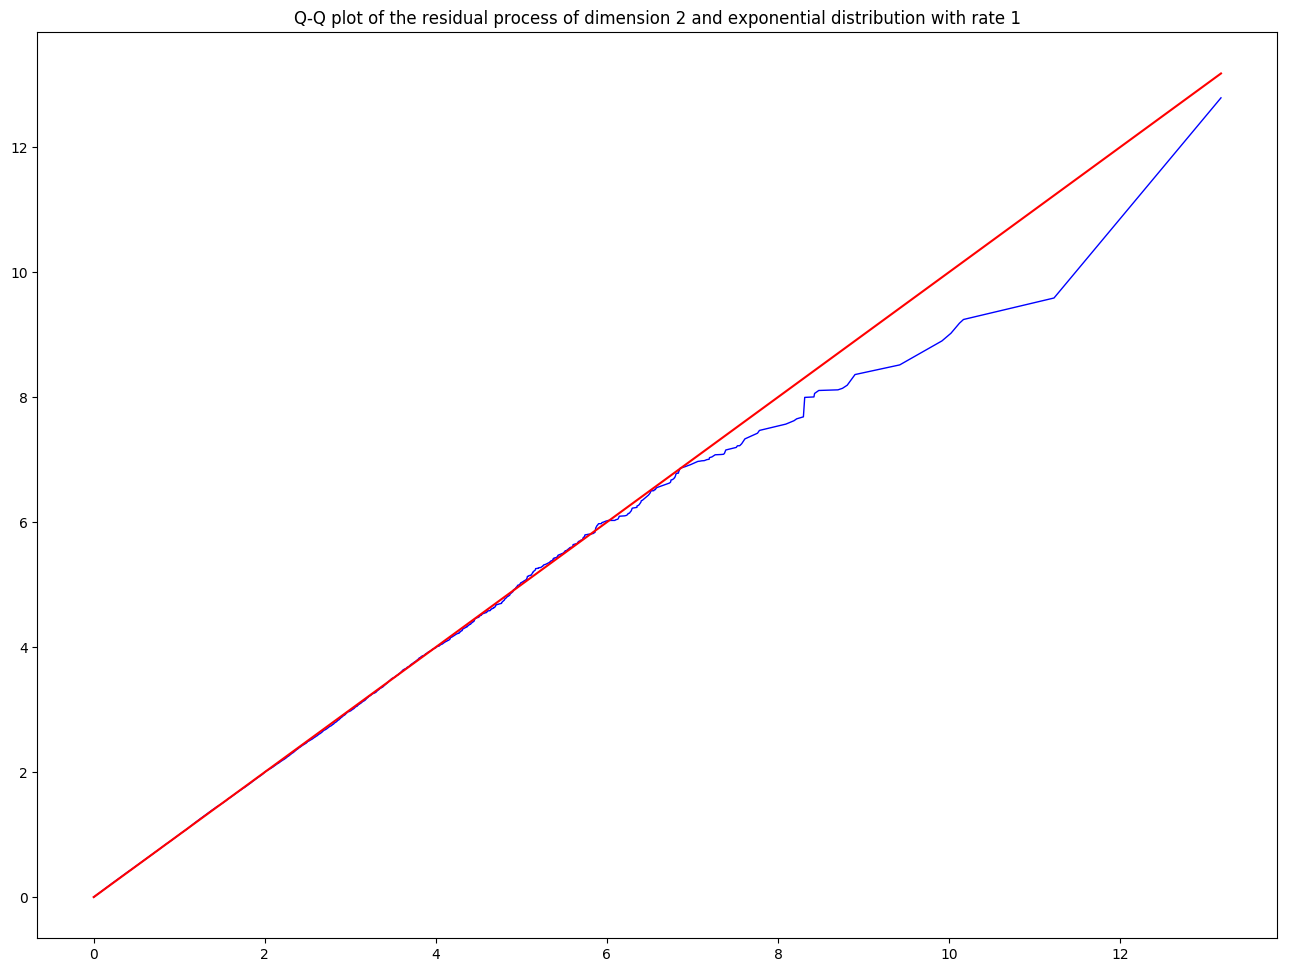

In [3]:
for i in range(dim):
    sorted_comp = sorted(comp[i])
    sorted_exp = np.sort(np.random.exponential(1, len(sorted_comp)))
    a = np.linspace(0, max(sorted_comp[-1], sorted_exp[-1]), len(sorted_comp))
    fig = plt.figure(figsize=(16, 12), dpi=100)
    plt.subplot(1, 1, 1)
    plt.plot(sorted_exp, sorted_comp, color="blue", linewidth=1.0, linestyle="-")
    plt.plot(a, a, color="red")
    plt.title("Q-Q plot of the residual process of dimension {} and exponential distribution with rate 1".format(i))
    plt.show()

We can see that the empirical distribution of residuals closely follows the exponential distribution with rate 1. Now, we will plot the distribution of events for each dimension.

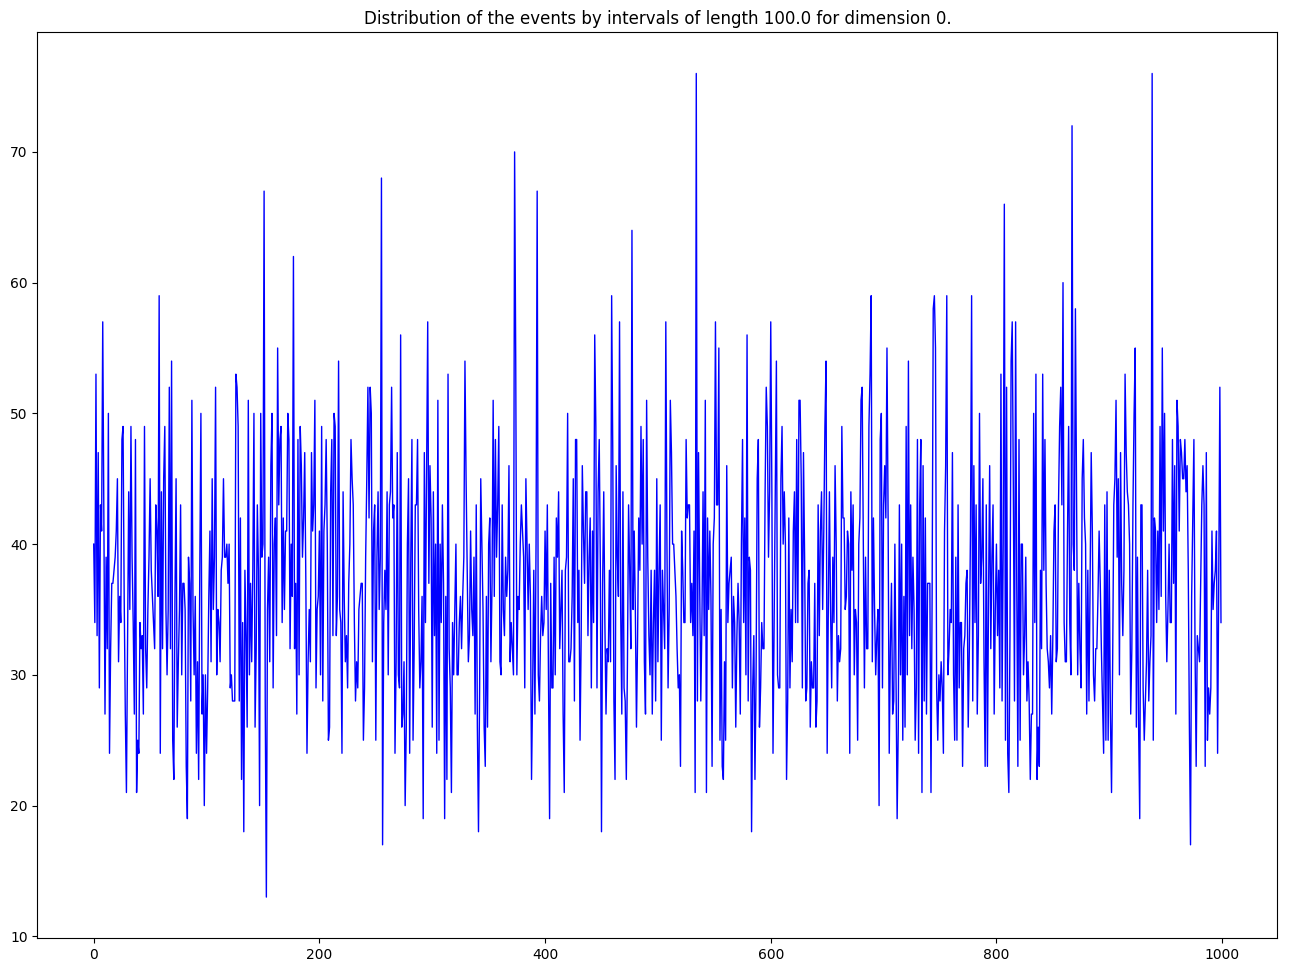

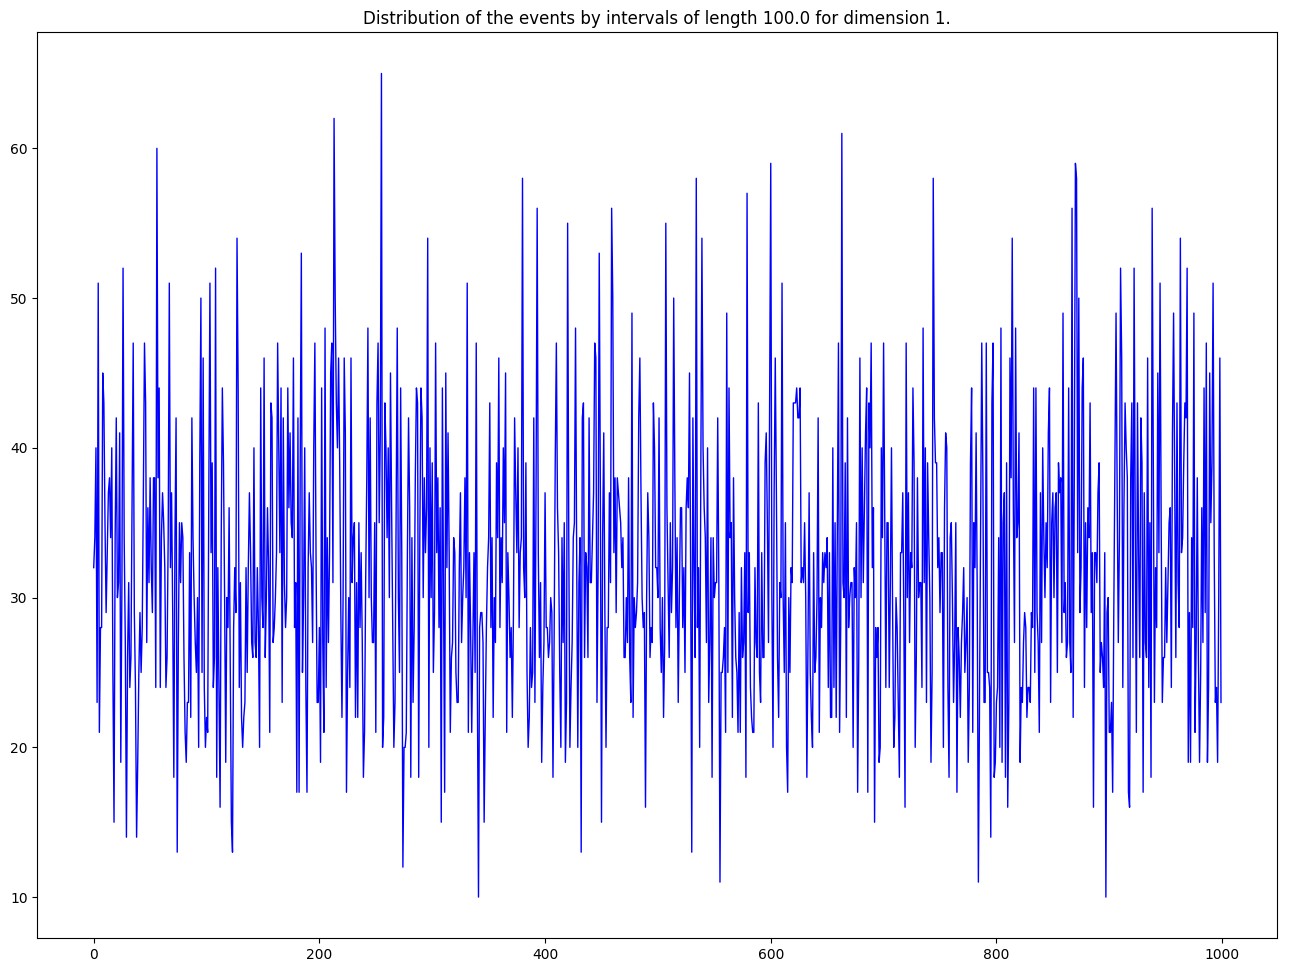

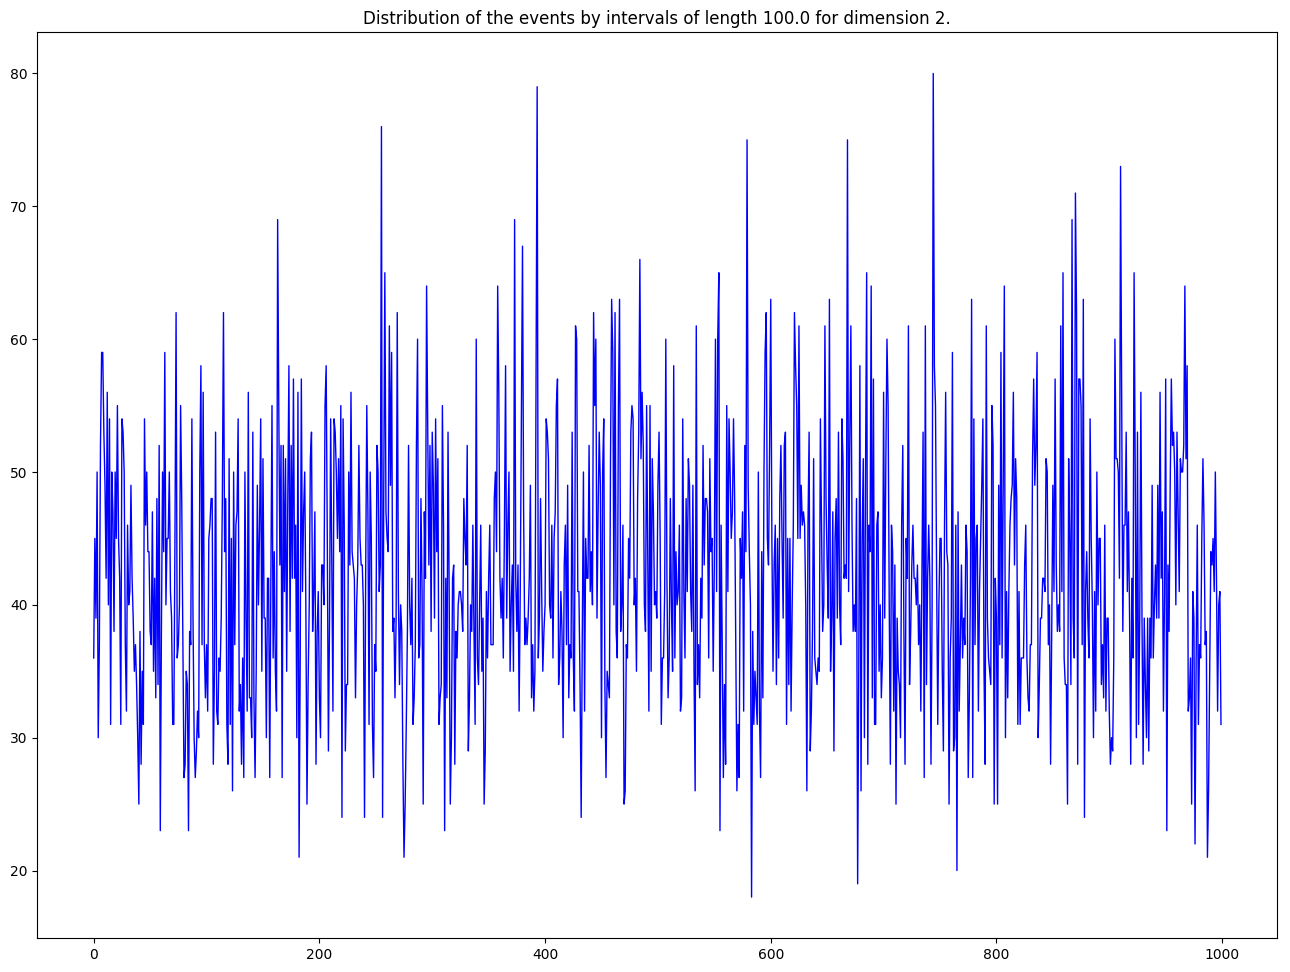

In [4]:
n_points = 1000
evol_hawkes = {i: np.zeros((n_points + 1, 2)) for i in range(dim)}
for i in range(dim):
    evol_hawkes[i][:, 0] = np.linspace(0, n_points, n_points + 1)
for i in range(dim):
    for j in range(len(hawkes[i])):
        index = int(hawkes[i][j] // (T / n_points))
        evol_hawkes[i][index, 1] += 1
for i in range(dim):
    fig = plt.figure(figsize=(16, 12), dpi=100)
    plt.subplot(1, 1, 1)
    plt.plot(evol_hawkes[i][:-1, 0], evol_hawkes[i][:-1, 1], color="blue", linewidth=1.0, linestyle="-",
             label="Number of events")
    plt.title("Distribution of the events by intervals of length {} for dimension {}.".format(T / n_points, i))
    plt.show()

And now, lets take a look at conditional intensity functions in an interval [1000, 1020] in a grid of 0.05. That means the conditional intensities will be valued at each 0.05 mark in an interval [1000, 1020], i.e. 1000, 1000.05, 1000.1..., and also at jump times for a given process. Jump timestamps will be plotted below the individual intensity functions.

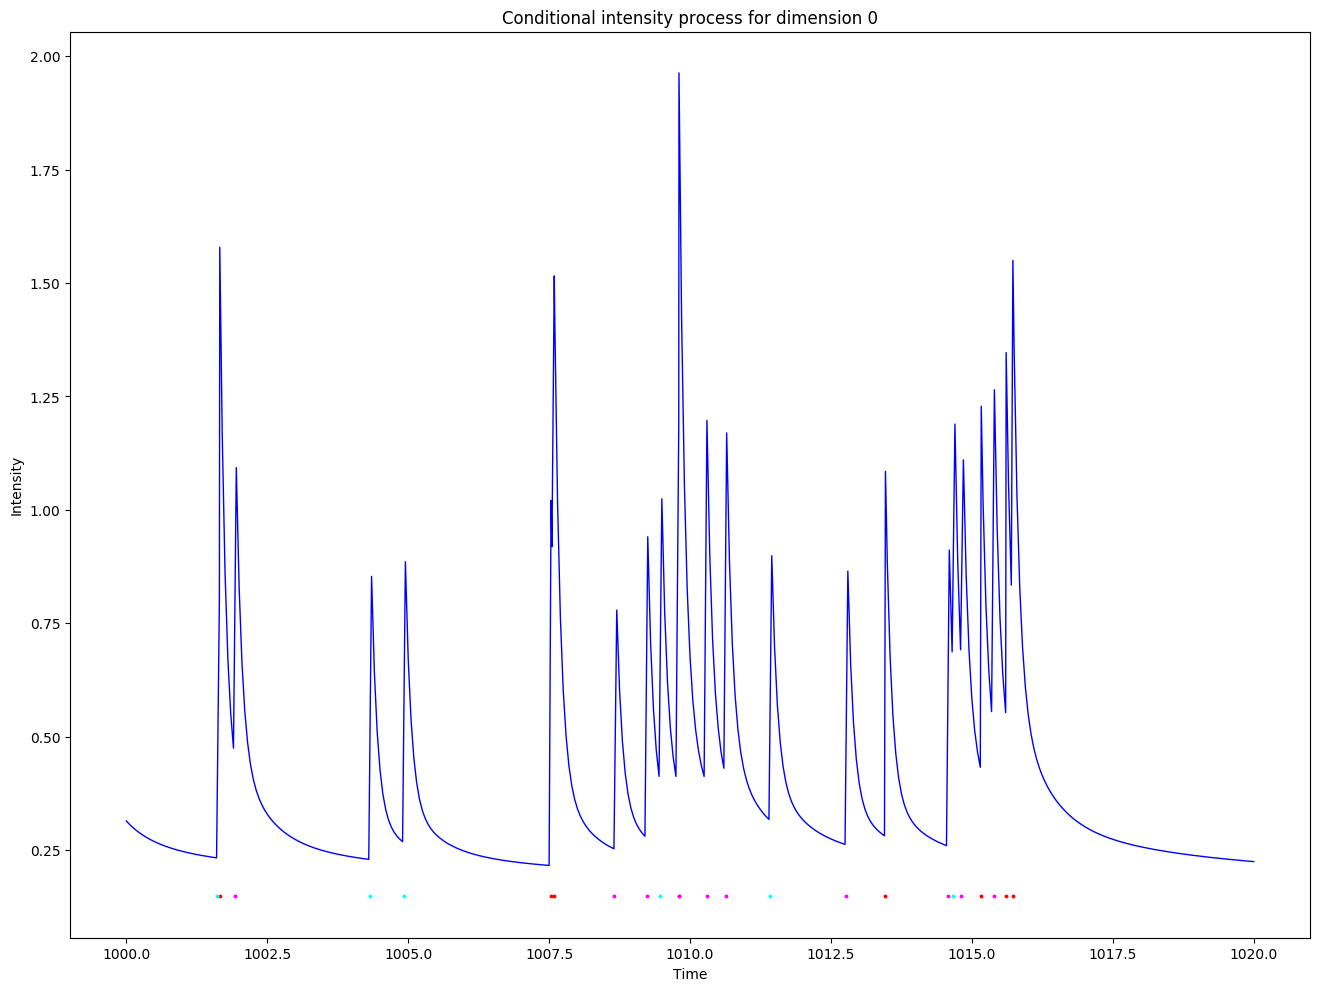

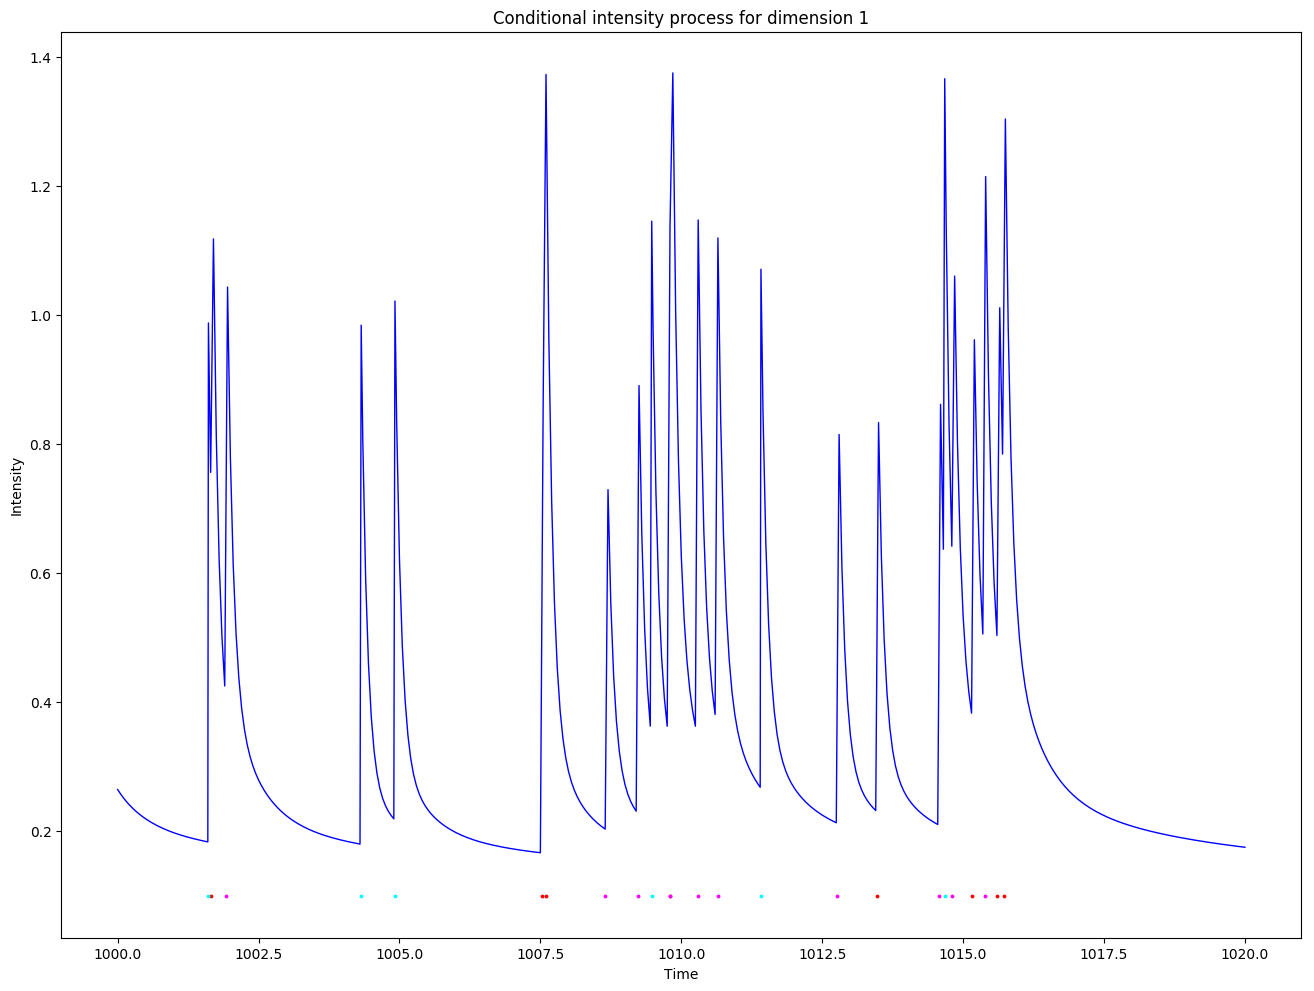

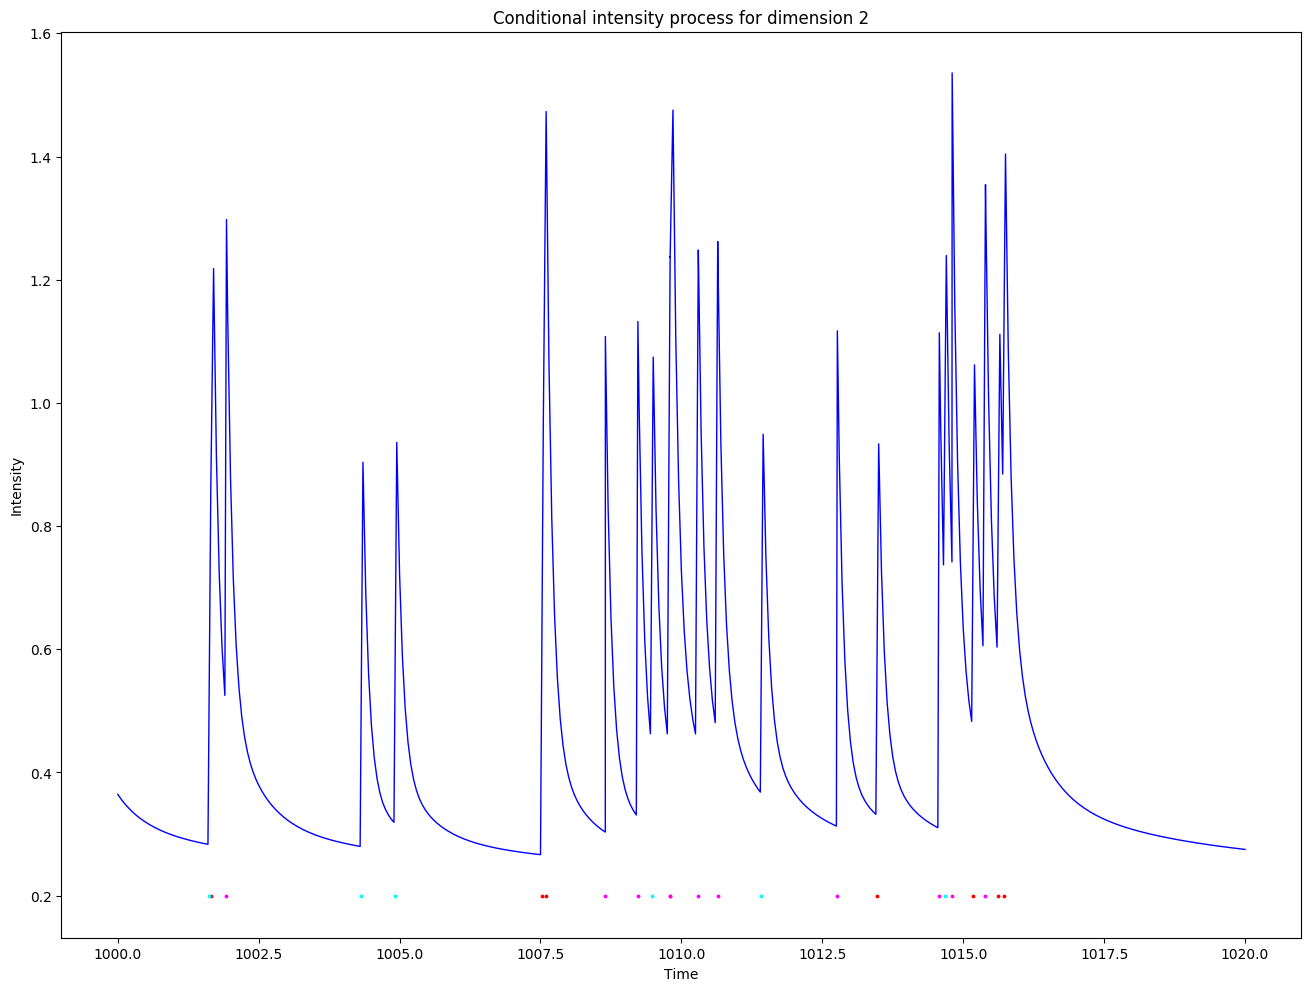

In [5]:
plot_range = (1000, 1020)
grid = 0.05

plt_y, plt_x = pyhawkes.plot_power_hawkes(mu, rho, m, M, epsilon, n, hawkes, T, plot_range[0], plot_range[1], grid)

events = [[] for i in range(dim)]
for i in range(dim):
    j = 0
    while hawkes[i][j] <= plot_range[1]:
        if hawkes[i][j] >= plot_range[0]:
            events[i].append(hawkes[i][j])
        j += 1

for i in range(dim):
    fig = plt.figure(figsize=(16, 12), dpi=100)
    plt.subplot(1, 1, 1)
    plt.plot(plt_x[i], plt_y[i], color="blue", linewidth=1.0, linestyle="-")
    plt.scatter(events[0], [mu[i]] * len(events[0]), color="red", marker="o", s=3, label = "Dimension 0")
    plt.scatter(events[1], [mu[i]] * len(events[1]), color="cyan", marker="o", s=3, label = "Dimension 1")
    plt.scatter(events[2], [mu[i]] * len(events[2]), color="magenta", marker="o", s=3, label = "Dimension 2")
    plt.xlabel('Time')
    plt.ylabel('Intensity')
    plt.title("Conditional intensity process for dimension {}".format(i))
    plt.show()

In contrast to the exponential kernel, we can observe that the intensity function almost never decays to its base intensity level. The long-memory is present in the cross- and self-excitation effects.

As a final exercise, we might want to see whether we can reliably estimate the parameters of the simulated Hawkes process. We will use scipy SLSQP procedure as it provides bounded and constrained minimization. Bounds will be given arbitrarily by a reasonable guess of an upper bound 20 (lower bound at zero is required by the definition of a Hawkes process) and constraints will impose stationarity condition on the parameters.

In [ ]:
n_params = dim + 3*dim**2

def constraint_slsqp(x):
    n = x[-dim**2:]
    n.shape = (dim, dim)
    evalues_g, _ = np.linalg.eig(n)
    return - np.max(np.abs(evalues_g)) + 1

bounds_slsqp = [(0.000001, 1) for _ in range(n_params)]

niter = 10
i = 0
hawkes_res = np.zeros((n_params, niter), dtype=float)
initial_params = np.zeros((n_params, niter), dtype=float)
fun_values = np.zeros(niter, dtype=float)
msg = np.zeros(niter, dtype=bool)
while i < niter:
    mu_init = np.random.uniform(0, 1, dim)
    rho_init = np.random.uniform(0, 1, dim**2)
    rho_init.shape = (dim, dim)
    epsilon_init = np.random.uniform(0, 1, dim**2)
    epsilon_init.shape = (dim, dim)
    n_init = np.random.uniform(0, 1, dim**2)
    n_init.shape = (dim, dim)
    evalues, _ = np.linalg.eig(n_init)
    if np.any(np.abs(evalues) >= 1):
        continue
    initial_params[:, i] = np.concatenate((mu_init, np.ndarray.flatten(rho_init), np.ndarray.flatten(epsilon_init), 
                                           np.ndarray.flatten(n_init)))
    partial_est_pl_hawkes = functools.partial(pyhawkes.lik_power_hawkes_optim, m=m, M=M, 
                                               events=hawkes, length=T)
    res = scipy.optimize.minimize(fun=partial_est_pl_hawkes, x0=initial_params[:, i],
                                  method="SLSQP", bounds=bounds_slsqp,
                                  constraints=({'type': 'ineq', 'fun': lambda x: constraint_slsqp(x)}),
                                  options={'maxiter': 20000, 'disp': False, 'ftol': 0.001})
    hawkes_res[:, i] = res.x
    fun_values[i] = res.fun
    msg[i] = res.message
    i += 1

mu_fnl = np.mean(hawkes_res[:dim, :], axis=1)
rho_fnl = np.mean(hawkes_res[dim:dim+dim**2, :], axis=1)
rho_fnl.shape = (dim, dim)
epsilon_fnl = np.mean(hawkes_res[dim+dim**2:dim+2*dim**2, :], axis=1)
epsilon_fnl.shape = (dim, dim)
n_fnl = np.mean(hawkes_res[dim+2*dim**2:, :], axis=1)
n_fnl.shape = (dim, dim)
evalues, _ = np.linalg.eig(n_fnl)
if np.any(np.abs(evalues) >= 1):
    print("UNSTABLE KERNEL")

print("Original MU: {}".format(mu))
print("Original RHO: {}".format(rho))
print("Original EPSILON: {}".format(epsilon))
print("Original N: {}".format(n))
print("")

print("Mean of estimated MU: {}".format(mu_fnl))
print("Mean of estimated RHO: {}".format(rho_fnl))
print("Mean of estimated EPSILON: {}".format(epsilon_fnl))
print("Mean of estimated N: {}".format(n_fnl))
print("")

print("Mean of negative log-likelihood: {}".format(fun_values.mean()))
print("")

print("Success rate: {}".format(msg.mean()))

As we can notice, the results obtained are quite accurate for all parameters.